# Reconstructing MNIST imaged with ScRRAMBLe-CapsNets
_Created on 07/24/25_

- Building up on the CapsNet approach for MNIST, the goal of this notebook is to verify if images can be reconstructed from capsule outputs.

In [8]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import json
import os
import pickle
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm import tqdm
from datetime import date


import matplotlib.pyplot as plt
import seaborn as sns

from models import ScRRAMBLeCapsLayer, ScRRAMBLeCapsNetWithReconstruction

from utils.activation_functions import quantized_relu_ste, squash
from utils.loss_functions import margin_loss
from utils import ScRRAMBLe_routing, intercore_connectivity, load_and_augment_mnist, plot_connectivity_matrix


import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

# Model

In [2]:
class ScRRAMBLeCapsNet(nnx.Module):
    """
    ScRRAMBLe CapsNet model for MNIST classification.

    Notes:
    - Currently assumes that the connection probability is the same for all the layers.
    """

    def __init__(
            self,
            input_vector_size: int, # size of flattened input vector
            capsule_size: int, # size of each capsule e.g. 256 (number of columns/rows of a core)
            receptive_field_size: int, # size of each receptive field e.g. 64 (number of columns/rows of a slot)
            connection_probability: float, # fraction of total receptive fields on sender side that each receiving slot/receptive field takes input from
            rngs: nnx.Rngs,
            layer_sizes: list = [20, 10, 10], # number of capsules in each layer of the capsnet. e.g. [20, 10] means 20 capsules in layer 1 and 10 capsules in layer 2
            activation_function: Callable = nnx.relu, # activation function to use in the network
    ):
        
        self.input_vector_size = input_vector_size
        self.capsule_size = capsule_size 
        self.receptive_field_size = receptive_field_size
        self.rngs = rngs
        self.connection_probability = connection_probability
        self.layer_sizes = layer_sizes
        self.activation_function = activation_function

        # calculate the effective capsules in input vector rouded to the nearest integral multiple of capsule size
        self.input_eff_capsules = math.ceil(self.input_vector_size/self.capsule_size)

        # add this element as the first element of layer_sizes
        self.layer_sizes.insert(0, self.input_eff_capsules)

        # define ScRRAMBLe capsules
        self.scrramble_caps_layers = [ScRRAMBLeCapsLayer(
            input_vector_size=self.capsule_size * Nci,
            num_capsules=Nco,
            capsule_size=self.capsule_size,
            receptive_field_size=self.receptive_field_size,
            connection_probability=self.connection_probability,
            rngs=self.rngs
        ) for Nci, Nco in zip(self.layer_sizes[:-1], self.layer_sizes[1:])]


    def __call__(self, x:jax.Array) -> jax.Array:
        """
        Forward pass through the ScRRAMBLe CapsNet
        """

        # resize the image to be (32, 32) for MNIST
        x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')

        # flatten the first two dimensions
        x = jnp.reshape(x, (x.shape[0], -1))

        # pass the input through the layers
        for layer in self.scrramble_caps_layers:
            x = jax.vmap(layer, in_axes=(0,))(x)
            x = jnp.reshape(x, (x.shape[0], -1))
            shape_x = x.shape
            # x = x.flatten()
            # x = jax.vmap(self.activation_function, in_axes=(0, None, None))(x, 8, 1.0) # 8 bits, 1.0 is the max clipping threshold.
            x = self.activation_function(x)  # Apply the activation function.
            x = jnp.reshape(x, shape_x)

        return x

## Reconstruction Network

In [2]:
class ReconstructionNetwork(nnx.Module):
    def __init__(self,
                 input_size: int,
                 rngs: nnx.Rngs):
        
        # define feedforward layers
        self.fc1 = nnx.Linear(input_size, 5000, rngs=rngs)
        self.fc2 = nnx.Linear(5000, 3000, rngs=rngs)
        self.fc3 = nnx.Linear(3000, 28*28, rngs=rngs)

    def __call__(self, x):

        x = nnx.relu(self.fc1(x))
        x = nnx.relu(self.fc2(x))
        x = nnx.sigmoid(self.fc3(x))

        return x

# Load the model from saved location

In [9]:
model_path = f"/local_disk/vikrant/scrramble/models/sscamble_mnist_capsnet_recon_capsules60_acc_99_2025-07-28.pkl"
training_metrics_path = f" /local_disk/vikrant/scrramble/logs/sscamble_mnist_capsnet_recon_capsules60_acc_99_2025-07-28.pkl"


# quantized relu playground

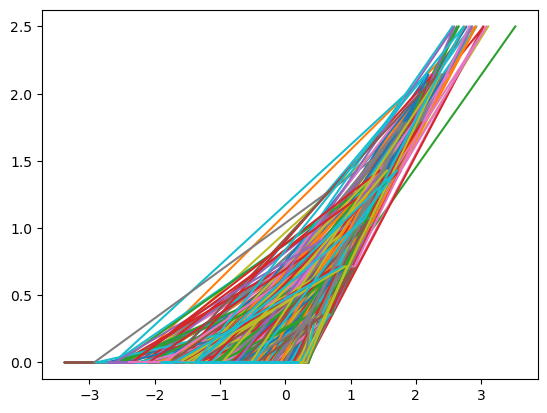

In [39]:
def qrelu_ptq(x: jax.Array,
              bits: int = 3,
              max_value:float = 2.0):
    """
    Quantized ReLU with quantization
    """

    num_levels = 2**bits - 1
    resolution = max_value/num_levels

    # apply ReLU to the input
    x = nnx.relu(x)

    # multiplier
    m = jnp.floor(x/resolution)

    # quantize the input
    x = jnp.clip(m * resolution, 0, max_value)

    return x

# testing
key = jax.random.key(1)
key, key2 = jax.random.split(key, 2)
x = jax.random.normal(key, (10, 250))
y = qrelu_ptq(x, bits=3, max_value=2.5)

plt.plot(x, y)

In [40]:
key = jax.random.key(10)
key1, key2, key3, key4 = jax.random.split(key, 4)
rngs = nnx.Rngs(params=key1, activations=key2, permute=key3, default=key4)

model = ScRRAMBLeCapsNetWithReconstruction(
    input_vector_size=1024,
    capsule_size=256,
    receptive_field_size=64,
    connection_probability=0.2,
    rngs=rngs,
    layer_sizes=[50, 10],  # 20 capsules in the first layer and (translates to sum of layer_sizes cores total)
    activation_function=qrelu_ptq
)



In [41]:
loaded_state = pickle.load(open(model_path, "rb"))
graphdef, old_state = nnx.split(model)
model = nnx.merge(graphdef, loaded_state)

## Let's evaluate the model

In [42]:
data_dir = "/local_disk/vikrant/datasets"
dataset_dict = {
    'batch_size': 100, # 64 is a good batch size for MNIST
    'train_steps': int(2e4), # run for longer, 20000 is good!
    'binarize': True, 
    'greyscale': True,
    'data_dir': data_dir,
    'seed': 101,
    'shuffle_buffer': 1024,
    'threshold' : 0.5, # binarization threshold, not to be confused with the threshold in the model
    'eval_every': 1000,
}

# loading the dataset
train_ds, valid_ds, test_ds = load_and_augment_mnist(
    batch_size=dataset_dict['batch_size'],
    train_steps=dataset_dict['train_steps'],
    data_dir=dataset_dict['data_dir'],
    seed=dataset_dict['seed'],
    shuffle_buffer=dataset_dict['shuffle_buffer'],
)



In [43]:
# test a batch
model.eval()
batch = next(iter(test_ds.as_numpy_iterator()))
recon_out, caps_out = model(batch['image'])
print(recon_out.shape)

(100, 784)


2025-07-31 17:22:16.184729: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [44]:
# writing the pred function
@nnx.jit
def pred_step(model: ScRRAMBLeCapsNetWithReconstruction, batch):
    """
    Prediction step for the ScRRAMBLe CapsNet model.
    """
    # Forward pass through the model
    recon_out, caps_out = model(batch['image'])
    
    # reshape
    out = jnp.reshape(caps_out, (caps_out.shape[0], 10, -1))

    # take vector sizes along hte final dimension
    out = jnp.linalg.norm(out, axis=-1)

    # take argmax along the second dimension to get the predicted class
    out = jnp.argmax(out, axis=-1)
    
    return out

# test
pred = pred_step(model, batch)
print(pred.shape)
print(pred[:10])  # Print the first 10 predictions
print(batch['label'][:10])  # Print the first 10 labels

(100,)
[2 0 4 8 7 6 0 6 3 1]
[2 0 4 8 7 6 0 6 3 1]


## Plotting reconstructions

2025-07-31 17:22:26.145629: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


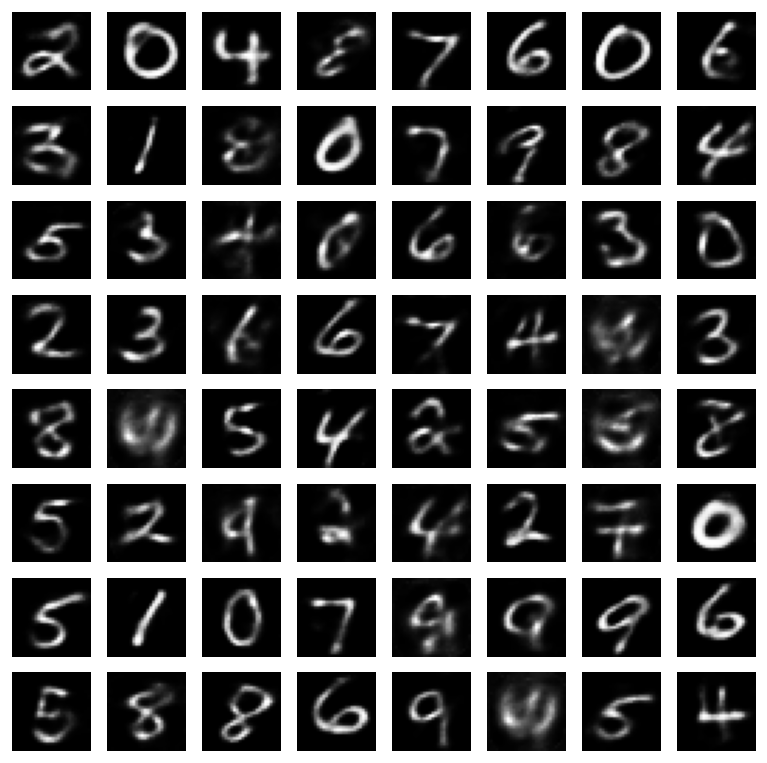

In [45]:
test_batch = next(iter(test_ds.as_numpy_iterator()))

recon, caps_out = model(test_batch['image'])

# plot the reconstructed images and their predicted labels
fig, ax = plt.subplots(8, 8, figsize=(8, 8), dpi=120)
for i, axs in zip(jnp.arange(64), ax.ravel()):
    im = axs.imshow(recon[i, :].reshape(28, 28), cmap='gray')
    axs.axis('off')

## Plotting weights

In [17]:
# visualize connectivity
caps_layers = model.scrramble_caps_layers
primary_parent_conn = caps_layers[1].visualize_connectivity()
primary_parent_conn.shape

(2560, 12800)

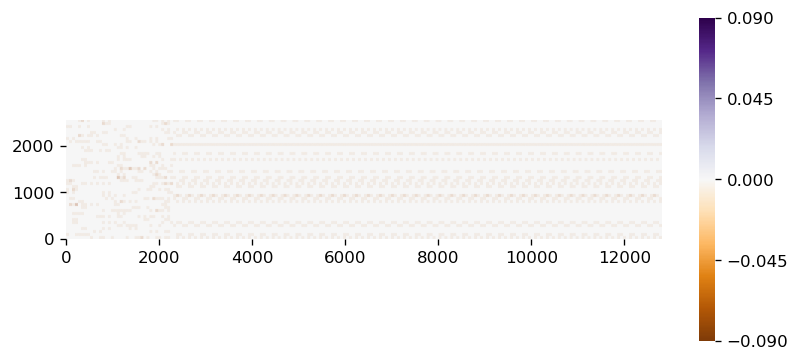

In [58]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
im = plt.imshow(primary_parent_conn, cmap='PuOr', vmax=0.09, vmin=-0.09, origin='lower')
cbar = plt.colorbar(im, ax=ax, ticks=[-0.09, -0.045, 0, 0.045, 0.09], shrink=0.7)
cbar.outline.set_visible(False)
sns.despine(fig, top=True, right=True, left=True, bottom=True)

(0.0, 40.0)

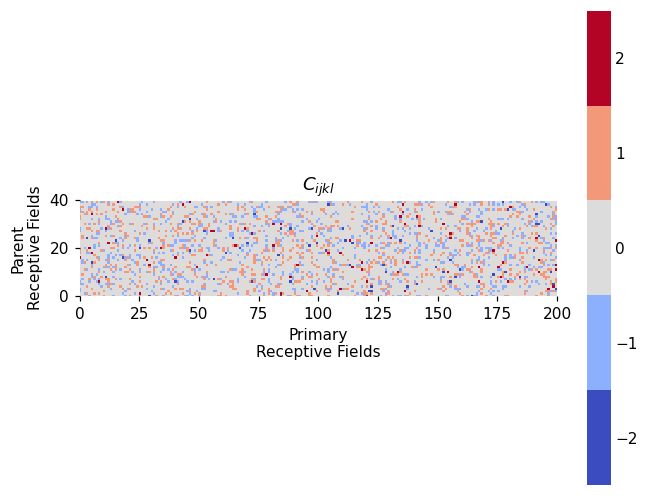

In [50]:
# visualize ScRRAMBLe Routing
sc_routing = caps_layers[1].Ci.value
fig, ax = plot_connectivity_matrix(sc_routing.T, figsize=(7, 7))
ax.set_xlabel("Primary\nReceptive Fields")
ax.set_ylabel("Parent\nReceptive Fields")

ax.set_xlim(0, 200)
ax.set_ylim(0, 40)


In [28]:
# untrained model
untrained_model = ScRRAMBLeCapsNetWithReconstruction(
    input_vector_size=1024,
    capsule_size=256,
    receptive_field_size=64,
    connection_probability=0.2,
    rngs=rngs,
    layer_sizes=[50, 10],  # 20 capsules in the first layer and (translates to sum of layer_sizes cores total)
    activation_function=nnx.relu
)

In [29]:
caps_layers = untrained_model.scrramble_caps_layers
primary_parent_conn = caps_layers[1].visualize_connectivity()
primary_parent_conn.shape

(2560, 12800)

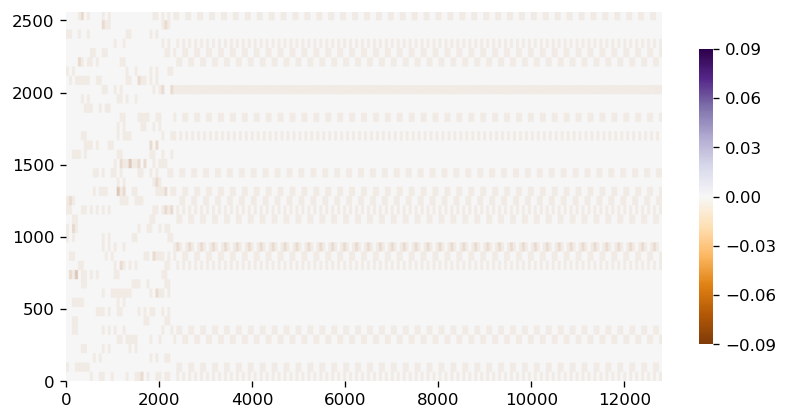

In [30]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
im = plt.imshow(primary_parent_conn, cmap='PuOr', aspect='auto', vmax=0.09, vmin=-0.09, origin='lower')
cbar = plt.colorbar(im, ax=ax, ticks=[-0.09, -0.06, -0.03, 0, 0.03, 0.06, 0.09], shrink=0.8)
cbar.outline.set_visible(False)
sns.despine(fig, top=True, right=True, left=True, bottom=True)

## Testing post training quantization results